# Piecewise linear regression

By Sang woo Ham (ecosang@gmail.com), Last edited on 09/09/2021

## Table of Contents

* [Introduction](#Introduction)
* [Piecewise linear regression](#Piecewise-linear-regression)
* [Parameter estimation](#Parameter-estimation)
* [Conclusion and discussion](#Conclusion-and-discussion)
* [References](#References)

# Introduction

This notebook is a simple Python demonstration of [piecewise linear regression](https://online.stat.psu.edu/stat501/lesson/8/8.8). Piecewise linear regression can be used to represent the relationship between outdoor air temperature and whole building energy consumption. This can be viewed as a simple data-driven model of a whole building energy consumption, and it has been widely used for retrofitting application [1,2,3].

In this document, We provide a reproducible Python notebook how to make a piecewise linear regression model so that one can apply the model to the building energy consumption data. First, we generate a toy dataset from the known piecewise linear regression model. Then, we provide an optimization based approach to estimate model parameters of the piecewise linear regression model.

# Piecewise linear regression

[Piecewise linear regression](https://online.stat.psu.edu/stat501/lesson/8/8.8) is a model that is composed of several linear regressions for different intervals of indepedent variables. This is useful when the behavior of depedent variable radically change in different intervals of indepdent variables (e.g., heating and cooling energy consumption with respect to outdoor air temperature). 

To generate the toy dataset, we assume we know the true model parameters of a piecewise linear model. The true model is a combination of two linear lines intersecting at $x=10$:

$$
\begin{align}
y &= -x+5 &\text{ if } &x<10 \\
y &= -x+5+3(x-10) &\text{ if } &x\geq10.
\end{align}
$$

This can be written in this format as shown in those references [1,2,3]:

$$y=5-x+3(x-10)^{+},$$

where $()^{+}$ is $0$ when the value in $()$ is less than $0$. Likewise, $()^{-}$ is $0$ when the value in $()$ is greater than $0$.

In real world, we don't have 100% accurate measurement. For the simplicity, all sources of uncertainties (e.g., measurement errors, noise in data generation process, etc.) are modeled as a single noise $\varepsilon$. We assume this noise follows a normal distribution of $\varepsilon_i \sim \text{N}(\mu_{\varepsilon}=0,\sigma_{\varepsilon}=2)$. 

With data specific index $i=1,2,...n$:

$$y_{i}=5-x_{i}+3(x_{i}-10)^{+}+\varepsilon_{i}.$$

Below code snippet shows how to generate the data.

In [1]:
# loading required packages.
import numpy as np # numpy for numerical calculation 
import matplotlib.pyplot as plt # visualization
%matplotlib inline

In [2]:
# fix seed to have consistent random number generation to make this example reproducible. 
np.random.seed(1234) 

# Data generation
n_data=100
x_data=np.random.uniform(-5,30,n_data) # Create x data in [-5,30]
e_data=np.random.normal(0,2.0,n_data) # e~Normal(0,2)
y_data=np.where(x_data<10,-1*(x_data)+5,-1*x_data+5+3*(x_data-10))+e_data # y data from model(x_data)+e

# Data to visualize the true model
x_grid=np.linspace(-5,30,36) 
y_grid=np.where(x_grid<10,-1*(x_grid)+5,-1*x_grid+5+3*(x_grid-10))

Below figure shows the generated data and true model in blue x and red line, respectively.  

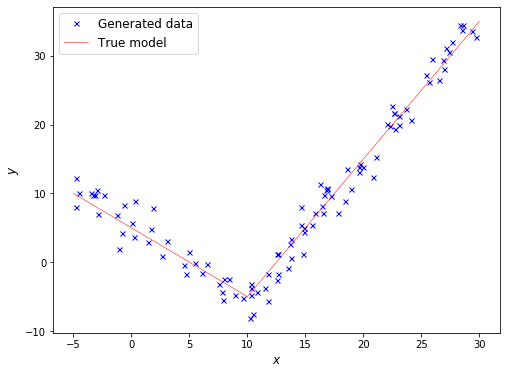

In [3]:
fig, ax =plt.subplots(nrows=1, ncols=1,  figsize=(8,6))
ax.plot(x_data,y_data,'bx',label="Generated data",markersize=5)
ax.plot(x_grid,y_grid,'r-',label="True model",linewidth=0.5)
ax.set_xlabel("$x$",fontsize=12)
ax.set_ylabel("$y$",fontsize=12)
ax.legend(loc="best",fontsize=12)

# Parameter estimation

Now, let's have a different view. We have data set (i.e., `x_data` and `y_data` in the above code, which are $\{x_i, y_i\}$ for $i=1,2,...n$). We want to find a piecewise linear regression model that explains the data. 

Let's parameterizes a piecewise linear regression in the following format:

$$y_{i}=\beta_0+\beta_{1}x_{i}+\beta_{2}(x_{i}-\beta_{3})^{+}+\varepsilon_{i},$$
where $\varepsilon_{i}\sim \text{N}(0,\sigma_{\varepsilon})$, and the unknown parameters are $\beta0$, $\beta1$, $\beta2$, $\beta3$, and $\sigma_{\varepsilon}$. 

There are two types of methods to estimate the parameters: (1) [least-squares method](https://en.wikipedia.org/wiki/Least_squares) and (2) [maximum likelihood estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). MLE method requires the understanding of probabilistic modeling, and both methods give same results for linear regression models with gaussian noise (i.e., $\varepsilon_{i}\sim \text{N}(0,\sigma_{\varepsilon})$). Therefore, we use least-square method in this notebook to estimate parameters. In this case, we don't need to explicitly estimate $\sigma_{\varepsilon}.$

Least-squares method is to find parameters that minimizes the sum of squares of prediction errors. When collecting all the parameters as $\theta=\{\beta_0, \beta_1, \beta_2, \text{ and } \beta_3 \}$, the least-squares soltuion of $\theta^{*}$ is estimated by solving:

$$\theta^{*}=\underset{\theta}{\arg\min} \sum_{i=1}^n \left(y_i-\hat{y}_i \right)^2,$$

where $\hat{y}_{i}=\beta_0+\beta_{1}x_{i}+\beta_{2}(x_{i}-\beta_{3})^{+}$.

This problem can be solved by using least-squares method for typical types of curves (linear or non-linear) implemented in [scipy package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). In addition, [numpy package](https://numpy.org/doc/stable/reference/generated/numpy.piecewise.html) provides a function to model the piecewise defined function. Please refer the comments in below code snippet.

In [4]:
# refer these sites
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# https://numpy.org/doc/stable/reference/generated/numpy.piecewise.html

# loading package
from scipy import optimize

def piecewise_linear(x, beta0, beta1, beta2, beta3):
    condlist = [x < beta3,  x >= beta3] # x<beta3 applies to lambda x: beta0+beta1*x. 
    funclist = [lambda x: beta0+beta1*x, lambda x: beta0+beta1*x+beta2*(x-beta3)]
    return np.piecewise(x, condlist, funclist) 

# estimate theta* and covariance of theta*
theta , theta_cov = optimize.curve_fit(piecewise_linear, x_data, y_data) #least square

Print the results. The least-squares method correctly estimate the parameters. One can notice the results are not exactly identical. This is we have limited number of data. When you increase `n_data=100` in data generation process, the estimation will be more accurate.

In [5]:

# beta0, beta1, beta2, beta3
print("Print results")
print(f'The estimated       beta0*:{round(theta[0],2)}, beta1*: {round(theta[1],2)}, beta2*: {round(theta[2],2)},  and  beta3*: {round(theta[3],2)}.') 
print(f'The true parameters beta0: 5.00, beta1 : -1.00, beta2 : 3.00, and  beta3 : 10.00')

Print results
The estimated       beta0*:5.57, beta1*: -1.11, beta2*: 3.2,  and  beta3*: 10.12.
The true parameters beta0: 5.00, beta1 : -1.00, beta2 : 3.00, and  beta3 : 10.00


Visualization. Although there is little difference, the method successfully identifies the piecewise linear regression model.

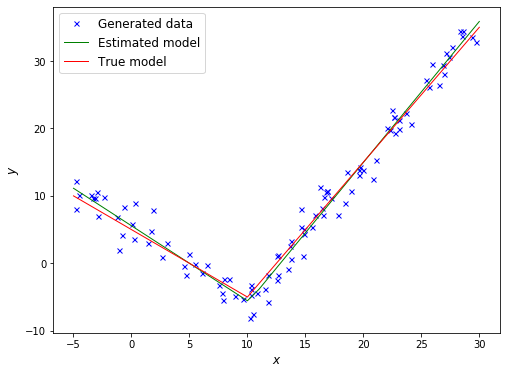

In [6]:
fig, ax =plt.subplots(nrows=1, ncols=1,  figsize=(8,6))
ax.plot(x_data, y_data, "bx",label="Generated data", markersize=5)
ax.plot(x_grid, piecewise_linear(x_grid, *theta),'g-',label='Estimated model',linewidth=1.0)
ax.plot(x_grid,y_grid,'r-',label='True model',linewidth=1.0)
ax.legend(fontsize=12,loc="best")
ax.set_xlabel("$x$",fontsize=12)
ax.set_ylabel("$y$",fontsize=12)

# Conclusion and discussion

In this notebook, we provide an introduction of a piecewise linear regression and a way to estimate model parameters from the data. The parameter estimation is achieved by an optimization-based method using `scipy` and `numpy` packages, and this method successfully estimated the model parameters. 

The formulation of the piecewise can be flexible. For example, if we want to have 0 slop below $\beta_{3}$, you can simply delete $\beta_{1}$ in the above example. Also, you can add one more change-point (or break point) in the above model. This can be simply achieved by adding `condlist` and `funclist` in the `piecewise_linear` function.

# References

[1] Kissock, J. K., Haberl, J. S., & Claridge, D. E. (2003). Inverse modeling toolkit: numerical algorithms. ASHRAE transactions, 109, 425. [(link)](http://www.eeperformance.org/uploads/8/6/5/0/8650231/ashrae_-_inverse_modeling_toolkit_-_numerical_algorithms.pdf)

[2] ASHRAE. (2014). ASHRAE Guideline 14–2014, Measurement of Energy, Demand, and Water Savings. [(link)](https://www.techstreet.com/standards/guideline-14-2014-measurement-of-energy-demand-and-water-savings?product_id=1888937)

[3] Server, F., Kissock, J. K., Brown, D., & Mulqueen, S. (2011). Estimating industrial building energy savings using inverse simulation. [(link)](https://ecommons.udayton.edu/cgi/viewcontent.cgi?article=1155&context=mee_fac_pub)